# Import

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

import torch
import torch.nn as nn
import torch.optim as optim

# Data Preprocessing

### Data Set split (train/test)

In [ ]:
final_dataframe = pd.read_csv('최종_매월의료데이터.csv')
#Train_test split
# 미충족 의료율 컬럼의 이상치 계산
q1 = final_dataframe['미충족 의료율'].quantile(0.25)  # 1사분위수
q3 = final_dataframe['미충족 의료율'].quantile(0.75)  # 3사분위수
iqr = q3 - q1                             # IQR 계산

lower_bound = q1 - 1.5 * iqr              # 하한선
upper_bound = q3 + 1.5 * iqr              # 상한선

# 이상치 데이터프레임
test_data = final_dataframe[(final_dataframe['미충족 의료율'] < lower_bound) | (final_dataframe['미충족 의료율'] > upper_bound)]

# 이상치가 없는 데이터프레임
train_data = final_dataframe[(final_dataframe['미충족 의료율'] >= lower_bound) & (final_dataframe['미충족 의료율'] <= upper_bound)]

### X,y split

In [ ]:
#X,Y 구분
x_label = ['진료실인원(계)', '진료비(계)', '급여비(계)', '진료실인원(관내)', '진료비(관내)', '급여비(관내)',
       '진료실인원(관외)', '진료비(관외)', '급여비(관외)', '상급종합병원', '종합병원',
       '의료보장', '근 로 자', '공ㆍ교', '지 역', '의료급여 1종', '의료급여 2종', '병원 총계',
       '병      원', '요양병원', '의      원', '치과병원', '치과의원', '한방병원', '한  의  원',
       '약      국', '보건소', '의료진 총계', '의        사', '치 과 의 사', '한    의    사',
       '간호사', '약  사', '물리치료사', '작업치료사', '사회복지사', '일반입원실 ', '중환자실  ', '자기공명영상기',
       '전산화단층촬영장치', '초음파', '20대', '30대', '40대', '50대', '60대', '70대', '80세 이상','시도','시군구', '년도', '월']

y_label = ['내과', '신경과', '외과', '정형외과', '소아청소년과', '안과', '이비인후과', '진단검사의학과',
       '피부/성형외과', '산부인과', '비뇨의학과', '심장혈관흉부외과', '한방관련', '미충족 의료율']
x_data = train_data[x_label]
y_data = train_data[y_label]
X_test = test_data[x_label]
Y_test = test_data[y_label]

### Transform

In [ ]:
#Transform

label_encoder = LabelEncoder()
x_data['시도'] = label_encoder.fit_transform(x_data['시도'])
x_data['시군구'] = label_encoder.fit_transform(x_data['시군구'])
X_test['시도'] = label_encoder.fit_transform(X_test['시도'])
X_test['시군구'] = label_encoder.fit_transform(X_test['시군구'])

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

scaler = StandardScaler()
x_train2 = scaler.fit_transform(x_train)
x_val2 = scaler.transform(x_val)
x_test2 = scaler.transform(X_test)

# PyTorch tensors
x_train = torch.tensor(x_train2, dtype=torch.float32)
y_train = torch.tensor(y_train.to_numpy(), dtype=torch.float32)
x_test = torch.tensor(x_test2, dtype=torch.float32)
y_test = torch.tensor(Y_test.to_numpy(), dtype=torch.float32)
x_val = torch.tensor(x_val2, dtype=torch.float32)
y_val = torch.tensor(y_val.to_numpy(), dtype=torch.float32)

<ipython-input-7-f3caaeacd178>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_data['시도'] = label_encoder.fit_transform(x_data['시도'])
<ipython-input-7-f3caaeacd178>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_data['시군구'] = label_encoder.fit_transform(x_data['시군구'])
<ipython-input-7-f3caaeacd178>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

# Modeling

In [ ]:
#Model
class DNNModel(nn.Module):
    def __init__(self):
        super(DNNModel, self).__init__()
        self.fc1 = nn.Linear(x_train.shape[1], 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 14)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#Train

In [ ]:
# 모델 및 데이터 GPU로 이동
model = DNNModel().to(device)
x_train, y_train = x_train.to(device), y_train.to(device)
x_val, y_val = x_val.to(device), y_val.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

best_val_loss = float('inf')

# losses and R2 scores
train_losses = []
val_losses = []
train_r2_scores = []
val_r2_scores = []

# Train the model
num_epochs = 2000
for epoch in range(num_epochs):
    # Training phase
    model.train()
    optimizer.zero_grad()
    outputs = model(x_train)
    train_loss = criterion(outputs, y_train)
    train_loss.backward()
    optimizer.step()

    # Calculate train R² score
    train_r2 = r2_score(
        y_train.detach().cpu().numpy(),
        outputs.detach().cpu().numpy()
    )

    # Validation phase
    model.eval()
    with torch.no_grad():
        val_outputs = model(x_val)
        val_loss = criterion(val_outputs, y_val)

        # Calculate validation R² score
        val_r2 = r2_score(
            y_val.detach().cpu().numpy(),
            val_outputs.detach().cpu().numpy()
        )

    # Save the model if validation loss improves
    if val_loss.item() < best_val_loss:
        best_val_loss = val_loss.item()
        torch.save(model.state_dict(), 'best_model.pth')

    # Store losses and R² scores for visualization
    train_losses.append(train_loss.item())
    val_losses.append(val_loss.item())
    train_r2_scores.append(train_r2)
    val_r2_scores.append(val_r2)

    # Log the losses and R² scores every 100 epochs
    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {train_loss.item():.4f}, Val Loss: {val_loss.item():.4f}, "
              f"Train R²: {train_r2:.4f}, Val R²: {val_r2:.4f}")


Epoch [100/2000], Train Loss: 829.0047, Val Loss: 967.6132, Train R²: 0.6702, Val R²: 0.6389
Epoch [200/2000], Train Loss: 360.9331, Val Loss: 396.6203, Train R²: 0.6944, Val R²: 0.6617
Epoch [300/2000], Train Loss: 283.4507, Val Loss: 308.0152, Train R²: 0.8020, Val R²: 0.7894
Epoch [400/2000], Train Loss: 237.6629, Val Loss: 258.6574, Train R²: 0.8224, Val R²: 0.8123
Epoch [500/2000], Train Loss: 208.4821, Val Loss: 225.8861, Train R²: 0.8385, Val R²: 0.8316
Epoch [600/2000], Train Loss: 177.5625, Val Loss: 189.5871, Train R²: 0.8588, Val R²: 0.8549
Epoch [700/2000], Train Loss: 150.7520, Val Loss: 158.1059, Train R²: 0.8771, Val R²: 0.8757
Epoch [800/2000], Train Loss: 129.1512, Val Loss: 132.8713, Train R²: 0.8843, Val R²: 0.8838
Epoch [900/2000], Train Loss: 111.3149, Val Loss: 113.2354, Train R²: 0.8903, Val R²: 0.8895
Epoch [1000/2000], Train Loss: 96.7312, Val Loss: 97.0944, Train R²: 0.8958, Val R²: 0.8946
Epoch [1100/2000], Train Loss: 85.2375, Val Loss: 86.1243, Train R²: 0.

#Plot

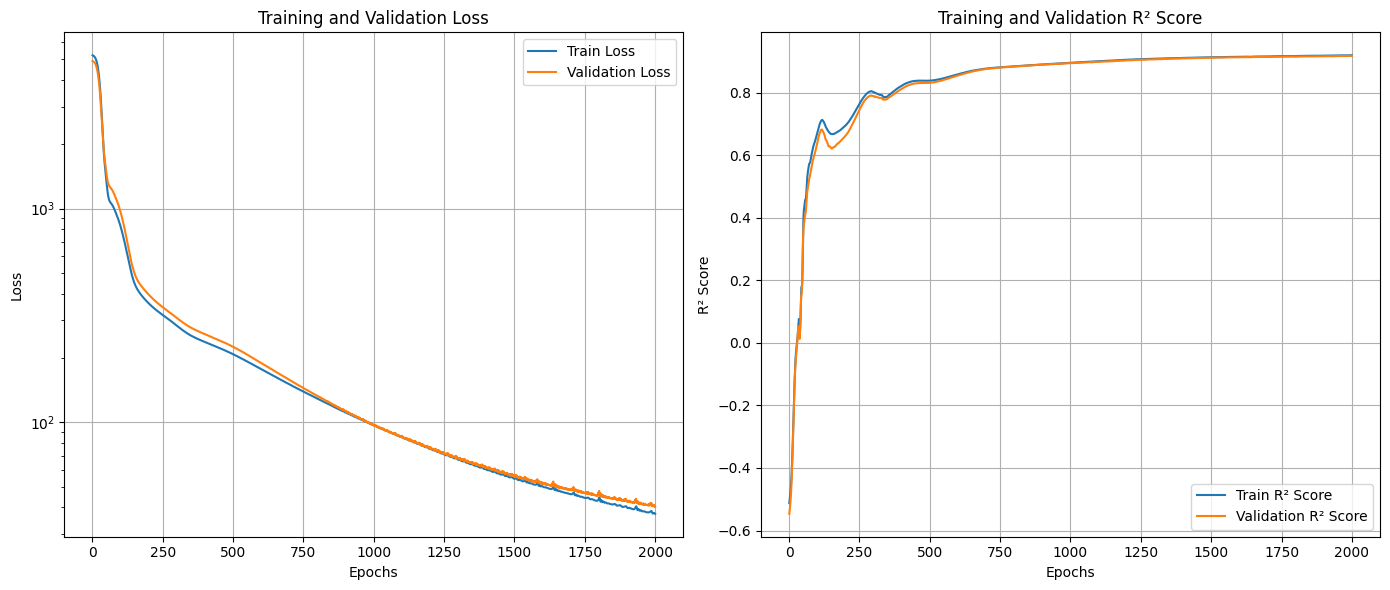

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # 한 줄에 두 개의 그래프 배치

# Loss 그래프
axes[0].plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
axes[0].plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
axes[0].set_yscale('log')  # Use logarithmic scale for better visualization
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True)

# R² 스코어 그래프
axes[1].plot(range(1, num_epochs + 1), train_r2_scores, label='Train R² Score')
axes[1].plot(range(1, num_epochs + 1), val_r2_scores, label='Validation R² Score')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('R² Score')
axes[1].set_title('Training and Validation R² Score')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()  # 그래프 간 간격 조정
plt.show()
